In [60]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.misc as misc
from numba import njit, jit
import sys
import legendre
from joblib import Parallel, delayed

tmax = 50
N = 300
dt = tmax/N
time = np.linspace(0, tmax, N)

tau = np.linspace(0, 0.99, 10)
xf = 1.5

# for V(q) = q^4 / 4 - q^2 / 2 from -1 to 0

def AP_pred(tau):
    x0 = -1
    xf = 0

    return 1/4  - tau ** 2 / 2 * (-0.25) #- tau**4 * 0.3

def MY_pred(tau):
    x0 = 0
    xf = 1.5
    return (xf**4 / 4 - 3*xf**3 / 2 + 9*xf**2 / 4) - (x0**4 / 4 - 3*x0**3 / 2 + 9*x0**2 / 4)  - tau ** 2 / 2 * (-6.40723) + tau / 2 * (xf**3 - 9*xf**2 / 2 + 9 * xf / 2)


def S_expected(tau):
    return xf**2 * (1 + tau) / 2

def action_adj(tau, pot, ini, fin, tm, N=250, maxiter=1500, lambd=0, a=0, init_cond=np.zeros(400), noise="d", b=1/2):
    test =  legendre.transform_adjust_2(lambda_=lambd, a=a, tau=tau, D1=0, D2=2, N=N, noise=noise, pot=pot, tmax=tm, const_i=ini, const_f=fin, b=b)
    res = test.minimize( maxiter=maxiter, in_cond=init_cond)
    return res.fun, res.x


def psi(q: np.ndarray, a: float, l: float, type: str, D=2, guess_size=1000):
    """_summary_

    Args:
        q (float): _description_
        a (float): _description_
        l (float): _description_
        type (str): _description_
        D (int, optional): _description_. Defaults to 2.
    """
    def phi(x):
        if type=="e":
            return x**2 / (2 * (1 - x**2))
        elif type=="d":
            return np.cosh(x) - 1
    
    optk = []
    if q[0] == 0:
        optk.append(0)
        V = q[1:]
    else:
        V = q
    

    K = np.linspace(1e-10, 1/a - 1e-3, num=guess_size)
    
    for x in V:
        
        aux = []
        if type=="e":
            K = np.linspace(1e-10, 1/a - 1e-3, num=guess_size)
        elif type=="d":
            K = np.linspace(start=1e-10, stop=x, num=guess_size)
        for k in K:
            p = D * k + l * phi(a * k) / k
            aux.append(np.abs(x - p))
        
        optimal_k = np.min(aux)
        ind = np.where(aux == optimal_k)[0]
        # print(ind, K[ind])
        optk.append(K[ind][0])

    return optk


def linear_tau_incl(k, a, l, type, D=2):
    
    def phi(x):
        if type=="e":
            return x**2 / (2 * (1 - x**2))
        elif type=="d":
            return np.cosh(x) - 1

    def dphi(x):
        if type=="e":
            return x / (1 - x**2)**2
        elif type=="d":
            return np.sinh(x)

    k0f = k[-1]

    return D / 2 * k0f ** 2 + l * a * k0f * dphi(a * k0f) - l * phi(a * k0f)



In [61]:
q = np.linspace(0, 1.5, 1000)

k0 = np.array(psi(q, 10, 0, "d", 2, 20000))

kc8 = np.array(psi(q, 10, 1e-8, "d", 2, 20000))
kc2 = np.array(psi(q, 10, 1e-2, "d", 2, 20000))

ke8 = np.array(psi(q, 10, 1e-8, "e", 2, 20000))
ke2 = np.array(psi(q, 10, 1e-2, "e", 2, 20000))

Ic8 = np.trapz(kc8, q)
Ic2 = np.trapz(kc2, q)
Ie8 = np.trapz(ke8, q)
Ie2 = np.trapz(ke2, q)
I0 = np.trapz(k0, q)

In [2]:
data = np.loadtxt("harmonic_simulations.txt")
res = data[0]
res_e = data[1]
res_e_low = data[2]
res_d = data[3]
res_d_low = data[4]

In [3]:
res_d2 = []
res_e2 = []
q_d2 = []
q_e2 = []
a = 10
l = 0.01
for t in tau:
    print("##################################")
    act_d = action_adj(t, "h", 0, 1.5, tm=50, N=300, lambd=l, a=a, noise="d")
    act_e = action_adj(t, "h", 0, 1.5, tm=50, N=300, lambd=l, a=a, noise="e")

    res_d2.append(act_d[0])
    res_e2.append(act_e[0])

    q_d2.append(act_d[1])
    q_e2.append(act_e[1])



##################################
lambda 	|	 1.000000e-02
 a 	|	 10.000000 
 tau 	|	 0.000000 
 D 	|	 2.000000 
 tmax 	|	 50.000000
 N 	|	 300

1.5 0
Noise: symmetric delta at +- 1
Optimization terminated successfully.
         Current function value: 0.460846
         Iterations: 62
         Function evaluations: 23177
         Gradient evaluations: 77
lambda 	|	 1.000000e-02
 a 	|	 10.000000 
 tau 	|	 0.000000 
 D 	|	 2.000000 
 tmax 	|	 50.000000
 N 	|	 300

1.5 0
Noise: symmetric exponential with characteristic scale 1
Optimization terminated successfully.
         Current function value: 0.139448
         Iterations: 53
         Function evaluations: 16856
         Gradient evaluations: 56
##################################
lambda 	|	 1.000000e-02
 a 	|	 10.000000 
 tau 	|	 0.110000 
 D 	|	 2.000000 
 tmax 	|	 50.000000
 N 	|	 300

1.5 0
Noise: symmetric delta at +- 1
Optimization terminated successfully.
         Current function value: 0.518786
         Iterations: 33
         

In [4]:
res_d8 = []
res_e8 = []
q_d8 = []
q_e8 = []
a = 10
l = 1e-8
for t in tau:
    print("##################################")
    act_d = action_adj(t, "h", 0, 1.5, tm=50, N=300, lambd=l, a=a, noise="d")
    act_e = action_adj(t, "h", 0, 1.5, tm=50, N=300, lambd=l, a=a, noise="e")

    res_d8.append(act_d[0])
    res_e8.append(act_e[0])

    q_d8.append(act_d[1])
    q_e8.append(act_e[1])

##################################
lambda 	|	 1.000000e-08
 a 	|	 10.000000 
 tau 	|	 0.000000 
 D 	|	 2.000000 
 tmax 	|	 50.000000
 N 	|	 300

1.5 0
Noise: symmetric delta at +- 1
Optimization terminated successfully.
         Current function value: 1.123755
         Iterations: 69
         Function evaluations: 22274
         Gradient evaluations: 74
lambda 	|	 1.000000e-08
 a 	|	 10.000000 
 tau 	|	 0.000000 
 D 	|	 2.000000 
 tmax 	|	 50.000000
 N 	|	 300

1.5 0
Noise: symmetric exponential with characteristic scale 1
Optimization terminated successfully.
         Current function value: 0.161120
         Iterations: 62
         Function evaluations: 19565
         Gradient evaluations: 65
##################################
lambda 	|	 1.000000e-08
 a 	|	 10.000000 
 tau 	|	 0.110000 
 D 	|	 2.000000 
 tmax 	|	 50.000000
 N 	|	 300

1.5 0
Noise: symmetric delta at +- 1
Optimization terminated successfully.
         Current function value: 1.246404
         Iterations: 33
         

In [33]:
def linear_tau_incl(k, a, l, type, D=2):
    
    def phi(x):
        if type=="e":
            return x**2 / (2 * (1 - x**2))
        elif type=="c":
            return np.cosh(x) - 1

    def dphi(x):
        if type=="e":
            return x / (1 - x**2)**2
        elif type=="c":
            return np.sinh(x)

    k0f = k[0]#k[-1]


    return D / 2 * k0f ** 2 + l * a * k0f * dphi(a * k0f) - l * phi(a * k0f)

def solver2( m_2, initial, lambda_=0.01, a=10, b=1/2, noise="d", D2=2):
    def phi(x):
        if noise=="e":
            return x**2 / (2 * (1 - x**2))
        elif noise=="c":
            return np.cosh(x) - 1
    
    def Eq2(k, m, a, lambda_):
        #print(k, np.cosh(a*k))
        return  k * m- D2/2 * k**2 - lambda_ * phi(a*k)

    k = np.linspace(-40, 40, 60000)
    if noise == "g" or noise == "e":
        k = np.linspace(-1/a + 1e-5, 1/a - 1e-5, 60000)
    
    K = []
    for M in m_2:
        e = Eq2(k, M, a, lambda_)
        f = np.argmax(e)
        K.append(k[f])


    return K

l = 0.01
a = 10
N = 300
tmax = 50

dt = tmax / N

k_d2 = []
lin_coeff_d2 = []

k_e2 = []
lin_coeff_e2 = []

for i in range(len(q_d2)):
    #test = legendre.transform_adjust_2(lambda_=l, a=a, tau=tau[i], D1=0, D2=2, N=N, noise="d", pot="h", tmax=tmax, const_i=0, const_f=1.5, b=0.5)
    initial = np.ones(N) * (1e-4)
    dq_dtest = np.zeros(N)
    dq_dtest[:-1] = (q_d2[i][1:] - q_d2[i][:-1]) / dt
    # b = test.solver2(q_d2[i] + dq_dtest, initial)
    b = np.array([solver2([1.5], 1e-4, l, a, noise="c")])
    # print(b)
    k_d2.append(b)
    lin_coeff_d2.append(linear_tau_incl(b, a, l, "c", D=2))

    #test = legendre.transform_adjust_2(lambda_=l, a=a, tau=tau[i], D1=0, D2=2, N=N, noise="e", pot="h", tmax=tmax, const_i=0, const_f=1.5, b=0.5)
    initial = np.ones(N) * (1e-4)
    dq_etest = np.zeros(N)
    dq_etest[:-1] = (q_e2[i][1:] - q_e2[i][:-1]) / dt
    #b = test.solver2(q_e2[i] + dq_etest, initial)
    b = np.array([solver2([1.5], 1e-4, l, a, noise="e")])
    # print(b)
    k_e2.append(b)
    lin_coeff_e2.append(linear_tau_incl(b, a, l, "e", D=2))



In [34]:
k_d8 = []
lin_coeff_d8 = []

k_e8 = []
lin_coeff_e8 = []

l = 1e-8
a = 10

for i in range(len(q_d2)):
    #test = legendre.transform_adjust_2(lambda_=l, a=a, tau=tau[i], D1=0, D2=2, N=N, noise="d", pot="h", tmax=tmax, const_i=0, const_f=1.5, b=0.5)
    initial = np.ones(N) * (1e-4)
    dq_dtest = np.zeros(N)
    dq_dtest[:-1] = (q_d2[i][1:] - q_d2[i][:-1]) / dt
    # b = test.solver2(q_d2[i] + dq_dtest, initial)
    b = np.array([solver2([1.5], 1e-4, l, a, noise="c")])
    # print(b)
    k_d8.append(b)
    lin_coeff_d8.append(linear_tau_incl(b, a, l, "c", D=2))

    #test = legendre.transform_adjust_2(lambda_=l, a=a, tau=tau[i], D1=0, D2=2, N=N, noise="e", pot="h", tmax=tmax, const_i=0, const_f=1.5, b=0.5)
    initial = np.ones(N) * (1e-4)
    dq_etest = np.zeros(N)
    dq_etest[:-1] = (q_e2[i][1:] - q_e2[i][:-1]) / dt
    #b = test.solver2(q_e2[i] + dq_etest, initial)
    b = np.array([solver2([1.5], 1e-4, l, a, noise="e")])
    # print(b)
    k_e8.append(b)
    lin_coeff_e8.append(linear_tau_incl(b, a, l, "e", D=2))

In [67]:
dq_etest = np.zeros(N)
dq_etest[:-1] = (q_e2[0][1:] - q_e2[0][:-1]) / dt
k_e22 = solver2(dq_dtest + q_e2[0], initial=dq_dtest, lambda_=0.01, a=10, D2=2, noise="e")
dq_etest[:-1] = (q_e8[0][1:] - q_e8[0][:-1]) / dt
k_e82 = solver2(dq_dtest + q_e8[0], initial=dq_dtest, lambda_=1e-8, a=10, D2=2, noise="e")
dq_etest[:-1] = (q_d2[0][1:] - q_d2[0][:-1]) / dt
k_d22 = solver2(dq_dtest + q_d2[0], initial=dq_dtest, lambda_=0.01, a=10, D2=2, noise="e")
dq_etest[:-1] = (q_d8[0][1:] - q_d8[0][:-1]) / dt
k_d82 = solver2(dq_dtest + q_d8[0], initial=dq_dtest, lambda_=1e-8, a=10, D2=2, noise="e")


Ic8t = np.trapz(k_d82, q_d8[0])
Ic2t = np.trapz(k_d22, q_d2[0])
Ie8t = np.trapz(k_e82, q_e8[0])
Ie2t = np.trapz(k_e22, q_e2[0])

In [69]:
print(Ic2, Ic2t)
print(Ic8, Ic8t)
print(Ie2, Ie2t)
print(Ie8, Ie8t)
print(2 / 27 * 2)

0.36162319132274545 0.12236985132788211
0.5624718736686458 0.14718604441045505
0.12932700386948412 0.11380336540424724
0.13869893732155544 0.14919022280639824
0.14814814814814814


In [47]:
print(k_d2)
print(k_d8)


print("#################################")

print(lin_coeff_d2)
print(lin_coeff_e2)
print(lin_coeff_d8)
print(lin_coeff_e8)

[array([[0.29133819]]), array([[0.29133819]]), array([[0.29133819]]), array([[0.29133819]]), array([[0.29133819]]), array([[0.29133819]]), array([[0.29133819]]), array([[0.29133819]]), array([[0.29133819]]), array([[0.29133819]])]
[array([[0.7500125]]), array([[0.7500125]]), array([[0.7500125]]), array([[0.7500125]]), array([[0.7500125]]), array([[0.7500125]]), array([[0.7500125]]), array([[0.7500125]]), array([[0.7500125]]), array([[0.7500125]])]
#################################
[array([0.27002837]), array([0.27002837]), array([0.27002837]), array([0.27002837]), array([0.27002837]), array([0.27002837]), array([0.27002837]), array([0.27002837]), array([0.27002837]), array([0.27002837])]
[array([0.10743203]), array([0.10743203]), array([0.10743203]), array([0.10743203]), array([0.10743203]), array([0.10743203]), array([0.10743203]), array([0.10743203]), array([0.10743203]), array([0.10743203])]
[array([0.56257753]), array([0.56257753]), array([0.56257753]), array([0.56257753]), array([

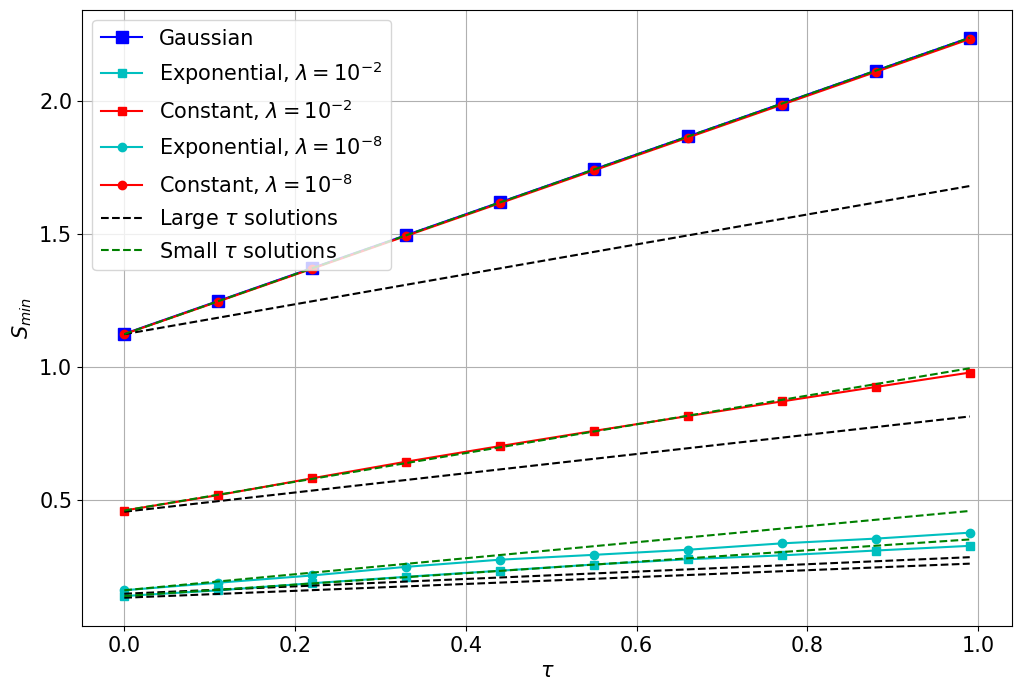

In [77]:
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(12, 8))

tau = np.linspace(0, 0.99, 10)

plt.plot(tau, res, "b-s", label="Gaussian", markersize=8)
# plt.plot(tau, res_e, "c-s", label=r"Exponential, $\lambda=10^{-2}$")
# plt.plot(tau, res_e_low, "c-x", label=r"Exponential, $\lambda=10^{-8}$")
# plt.plot(tau, res_d, "g-s", label=r"Constant, $\lambda=10^{-2}$")
# plt.plot(tau, res_d_low, "g-x", label=r"Constant, $\lambda=10^{-8}$")

plt.plot(tau, res_e2, "c-s", label=r"Exponential, $\lambda=10^{-2}$")
plt.plot(tau, res_d2, "r-s", label=r"Constant, $\lambda=10^{-2}$")

plt.plot(tau, res_e8, "c-o", label=r"Exponential, $\lambda=10^{-8}$")
plt.plot(tau, res_d8, "r-o", label=r"Constant, $\lambda=10^{-8}$")

plt.plot(tau, Ic8 * tau + res_d_low[0], "k--", label=r"Large $\tau$ solutions")
plt.plot(tau, Ic2 * tau + res_d[0], "k--")
plt.plot(tau, Ie8 * tau + res_e_low[0], "k--")
plt.plot(tau, Ie2 * tau + res_e[0], "k--")

plt.plot(tau, 2*lin_coeff_d2[0] * tau + res_d2[0], "g--", label=r"Small $\tau$ solutions")
plt.plot(tau, 2*lin_coeff_e2[0] * tau + res_e2[0], "g--")


plt.plot(tau, 2*lin_coeff_d8[0] * tau + res_d8[0], "g--")
plt.plot(tau, 2*lin_coeff_e8[0] * tau + res_e8[0], "g--")



# plt.plot(tau,  linear_tau_incl(kc8, 10, 1e-8, "c", 2)/2*tau + res_d_low[0], "y--", label=r"Small $\tau$ solutions")
# plt.plot(tau,  linear_tau_incl(kc2, 10, 1e-2, "c", 2)/2*tau + res_d[0], "y--")
# plt.plot(tau,  linear_tau_incl(ke8, 10, 1e-8, "e", 2)/2*tau + res_e_low[0], "y--")
# plt.plot(tau, linear_tau_incl(ke2, 10, 1e-2, "e", 2)/2*tau + res_e[0], "y--")


# plt.plot(tau, S_expected(tau), "b--", label="Analytic")
# plt.plot([-0.1, 1.1], np.ones(2) * xf**2 / 2, "k", linestyle="dotted", label=r"$q_f^2/D$")

#plt.axis([-0.05, 1.05, 1.1, 2.3])
plt.xlabel(r"$\tau$")
plt.ylabel(r"$S_{min}$")
plt.grid()
plt.legend(loc="upper left")
# plt.xscale("log")
plt.savefig("harmonic_tau_limits.pdf", dpi=500, bbox_inches="tight")

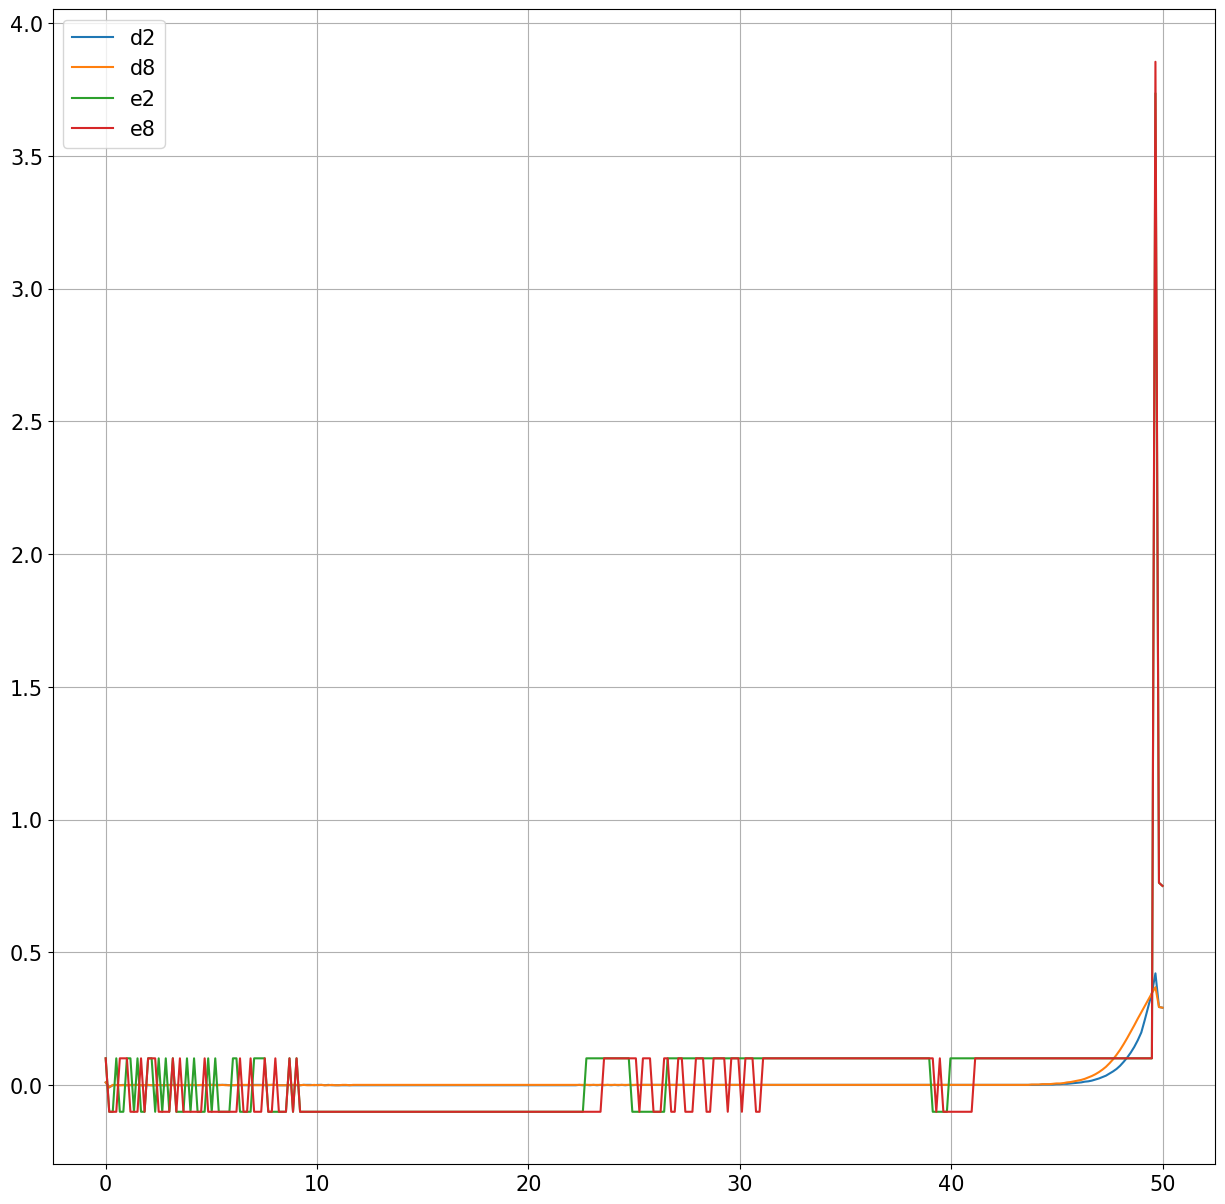

In [20]:
t = np.linspace(0, tmax, N)

fig = plt.figure(figsize=(15, 15))
plt.plot(t, k_d2[0], label="d2")
plt.plot(t, k_d8[0], label="d8")
plt.plot(t, k_e2[0], label="e2")
plt.plot(t, k_e8[0], label="e8")


plt.legend()
plt.grid()